# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import mlflow
from collections import defaultdict
from scipy.stats import zscore

# original library

import common as com
import pytorch_modeler as modeler
from pytorch_model import LSTM_AutoEncoder as Model
from pytorch_utils import filtered_load_model
import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
#with open("./config.yaml", 'rb') as f:
#    config = yaml.load(f)

log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/working/research/dcase2020/result/2D/LSTM_CONV_VAE2/config.yaml'

## make path list and train/valid split

In [7]:
############################################################################
# make path set and train/valid split
############################################################################
'''
train_paths[machine_type]['train' or 'valid'] = path
'''
dev_train_paths = {}
add_train_paths = {}
train_paths = {}

In [8]:
for machine_type in machine_types:
    # dev train
    dev_train_paths = ["{}/{}/train/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(dev_path, machine_type))]
    dev_train_paths = sorted(dev_train_paths)
    # add_dev train
    add_train_paths = ["{}/{}/train/".format(add_dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(add_dev_path, machine_type))]
    add_train_paths = sorted(add_train_paths)
    # valid
    dev_valid_paths = ["{}/{}/test/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/test".format(dev_path, machine_type))]
    dev_valid_paths = sorted(dev_valid_paths)
    
    train_paths[machine_type] = {}
    train_paths[machine_type]['train'] = dev_train_paths + add_train_paths
    train_paths[machine_type]['valid'] = dev_valid_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(train_paths, machine_type)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)         # debug
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['preprocessing']['sample_rate'],
                window_size=config['preprocessing']['window_size'],
                hop_size=config['preprocessing']['hop_size'],
                mel_bins=config['preprocessing']['mel_bins'],
                fmin=config['preprocessing']['fmin'],
                fmax=config['preprocessing']['fmax'])
    #pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
    #net = filtered_load_model(net, pretrained_dict)
    optimizer = optim.Adam(net.parameters())
    criterion = nn.MSELoss()
    num_epochs = config['fit']['num_epochs']
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    history = modeler.train_net(net, dataloaders_dict, criterion, optimizer, scheduler, num_epochs, writer)
    # output
    model = history['model']
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    torch.save(model.state_dict(), model_out_path)
    logger.info('\n success:{0} \n'.format(machine_type) + \
                    'model_out_path ==> \n {0}'.format(model_out_path))
    #  close writer for tensorbord
    writer.close()
    #modeler.mlflow_log(history, config, machine_type, model_out_path, tb_log_dir)
    com.toc()
    return history

In [10]:
machine_types

['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

2020-11-18 02:21:15,308 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2020-11-18 02:21:15,309 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-18 02:21:16,147 - 00_train.py - INFO - TRAINING


use: cuda:0


100%|██████████| 1803/1803 [00:23<00:00, 76.68it/s]


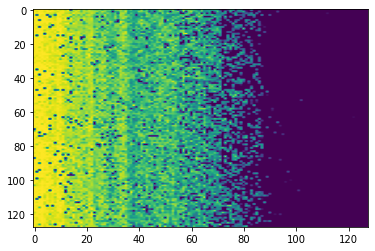

2020-11-18 02:22:43,487 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:0.043772, valid_AUC:0.476454, valid_pAUC:0.496230
100%|██████████| 1803/1803 [00:23<00:00, 76.76it/s]
2020-11-18 02:24:07,484 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:4831.774114, valid_AUC:0.471559, valid_pAUC:0.498124
100%|██████████| 1803/1803 [00:23<00:00, 76.99it/s]
2020-11-18 02:25:32,175 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:3.393119, valid_AUC:0.477343, valid_pAUC:0.504614
100%|██████████| 1803/1803 [00:24<00:00, 74.84it/s]
2020-11-18 02:26:58,178 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:1.038543, valid_AUC:0.502224, valid_pAUC:0.509557
100%|██████████| 1803/1803 [00:23<00:00, 75.42it/s]


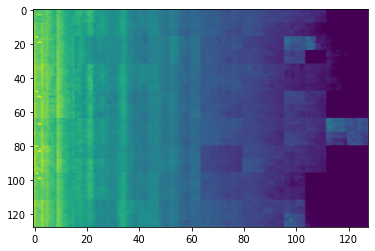

2020-11-18 02:28:24,013 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:2.703498, valid_AUC:0.486896, valid_pAUC:0.507493
100%|██████████| 1803/1803 [00:23<00:00, 77.06it/s]
2020-11-18 02:29:48,418 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:0.124832, valid_AUC:0.496851, valid_pAUC:0.501632
100%|██████████| 1803/1803 [00:23<00:00, 76.15it/s]
2020-11-18 02:31:14,300 - pytorch_modeler.py - INFO - Epoch 7/100:train_loss:0.097996, valid_AUC:0.500729, valid_pAUC:0.503761
100%|██████████| 1803/1803 [00:23<00:00, 77.17it/s]
2020-11-18 02:32:37,933 - pytorch_modeler.py - INFO - Epoch 8/100:train_loss:0.369497, valid_AUC:0.499059, valid_pAUC:0.505524
100%|██████████| 1803/1803 [00:23<00:00, 77.00it/s]
2020-11-18 02:34:03,080 - pytorch_modeler.py - INFO - Epoch 9/100:train_loss:0.032409, valid_AUC:0.493475, valid_pAUC:0.506809
100%|██████████| 1803/1803 [00:23<00:00, 77.24it/s]


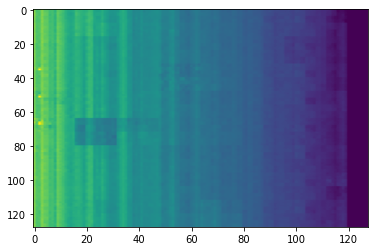

2020-11-18 02:35:28,203 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:0.028601, valid_AUC:0.493548, valid_pAUC:0.506171
100%|██████████| 1803/1803 [00:23<00:00, 76.86it/s]
2020-11-18 02:36:52,160 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:0.026865, valid_AUC:0.488913, valid_pAUC:0.505243
100%|██████████| 1803/1803 [00:23<00:00, 76.84it/s]
2020-11-18 02:38:17,166 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:0.025274, valid_AUC:0.484957, valid_pAUC:0.507868
100%|██████████| 1803/1803 [00:23<00:00, 77.34it/s]
2020-11-18 02:39:40,714 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:0.024173, valid_AUC:0.486775, valid_pAUC:0.507606
100%|██████████| 1803/1803 [00:23<00:00, 77.12it/s]
2020-11-18 02:41:04,283 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:0.023300, valid_AUC:0.487548, valid_pAUC:0.508337
100%|██████████| 1803/1803 [00:23<00:00, 76.99it/s]


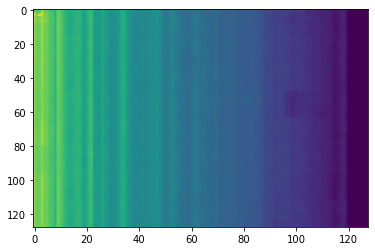

2020-11-18 02:42:28,029 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:0.022681, valid_AUC:0.486053, valid_pAUC:0.506687
100%|██████████| 1803/1803 [00:22<00:00, 79.00it/s]
2020-11-18 02:43:50,916 - pytorch_modeler.py - INFO - Epoch 16/100:train_loss:0.022249, valid_AUC:0.488847, valid_pAUC:0.509528
100%|██████████| 1803/1803 [00:22<00:00, 78.90it/s]
2020-11-18 02:45:13,675 - pytorch_modeler.py - INFO - Epoch 17/100:train_loss:0.021952, valid_AUC:0.486030, valid_pAUC:0.509594
100%|██████████| 1803/1803 [00:22<00:00, 78.86it/s]
2020-11-18 02:46:36,485 - pytorch_modeler.py - INFO - Epoch 18/100:train_loss:0.021731, valid_AUC:0.485282, valid_pAUC:0.510644
100%|██████████| 1803/1803 [00:22<00:00, 79.04it/s]
2020-11-18 02:47:59,198 - pytorch_modeler.py - INFO - Epoch 19/100:train_loss:0.021054, valid_AUC:0.483754, valid_pAUC:0.509697
100%|██████████| 1803/1803 [00:22<00:00, 78.83it/s]


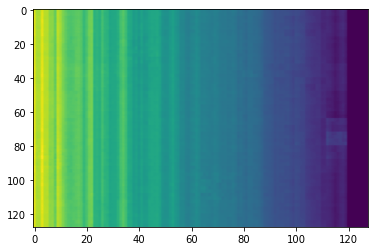

2020-11-18 02:49:22,107 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:0.021014, valid_AUC:0.487969, valid_pAUC:0.508647
100%|██████████| 1803/1803 [00:22<00:00, 78.94it/s]
2020-11-18 02:50:44,860 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:0.020585, valid_AUC:0.484679, valid_pAUC:0.509913
100%|██████████| 1803/1803 [00:22<00:00, 79.02it/s]
2020-11-18 02:52:07,568 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:0.020132, valid_AUC:0.487010, valid_pAUC:0.509407
100%|██████████| 1803/1803 [00:22<00:00, 78.87it/s]
2020-11-18 02:53:30,341 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:0.019824, valid_AUC:0.487325, valid_pAUC:0.510326
100%|██████████| 1803/1803 [00:22<00:00, 78.90it/s]
2020-11-18 02:54:53,100 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:0.019484, valid_AUC:0.488093, valid_pAUC:0.509866
100%|██████████| 1803/1803 [00:22<00:00, 78.80it/s]


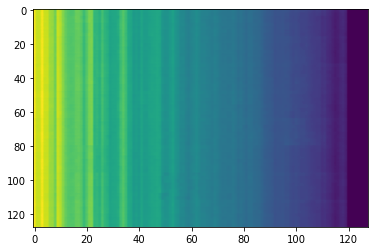

2020-11-18 02:56:16,027 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:0.019285, valid_AUC:0.484068, valid_pAUC:0.509894
100%|██████████| 1803/1803 [00:22<00:00, 78.80it/s]
2020-11-18 02:57:38,822 - pytorch_modeler.py - INFO - Epoch 26/100:train_loss:0.019100, valid_AUC:0.487079, valid_pAUC:0.509979
100%|██████████| 1803/1803 [00:22<00:00, 78.82it/s]
2020-11-18 02:59:01,636 - pytorch_modeler.py - INFO - Epoch 27/100:train_loss:0.018962, valid_AUC:0.483058, valid_pAUC:0.508459
100%|██████████| 1803/1803 [00:22<00:00, 78.72it/s]
2020-11-18 03:00:24,497 - pytorch_modeler.py - INFO - Epoch 28/100:train_loss:0.018829, valid_AUC:0.486933, valid_pAUC:0.509688
100%|██████████| 1803/1803 [00:22<00:00, 78.74it/s]
2020-11-18 03:01:47,302 - pytorch_modeler.py - INFO - Epoch 29/100:train_loss:0.018706, valid_AUC:0.488019, valid_pAUC:0.510260
100%|██████████| 1803/1803 [00:22<00:00, 78.62it/s]


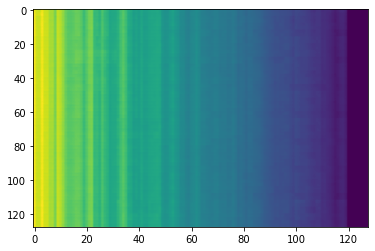

2020-11-18 03:03:10,254 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:0.018578, valid_AUC:0.485738, valid_pAUC:0.509247
100%|██████████| 1803/1803 [00:22<00:00, 78.97it/s]
2020-11-18 03:04:33,044 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:0.018482, valid_AUC:0.488516, valid_pAUC:0.509275
100%|██████████| 1803/1803 [00:22<00:00, 78.80it/s]
2020-11-18 03:05:55,818 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:0.018410, valid_AUC:0.485110, valid_pAUC:0.509613
100%|██████████| 1803/1803 [00:22<00:00, 78.63it/s]
2020-11-18 03:07:18,699 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:0.018306, valid_AUC:0.485248, valid_pAUC:0.509022
100%|██████████| 1803/1803 [00:22<00:00, 79.08it/s]
2020-11-18 03:08:41,397 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:0.018231, valid_AUC:0.484218, valid_pAUC:0.507887
100%|██████████| 1803/1803 [00:22<00:00, 78.80it/s]


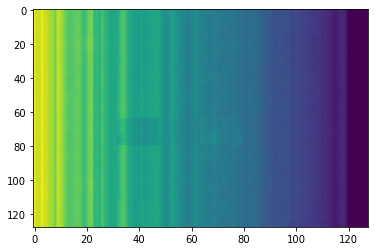

2020-11-18 03:10:04,312 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:0.018165, valid_AUC:0.484743, valid_pAUC:0.510007
100%|██████████| 1803/1803 [00:22<00:00, 78.71it/s]
2020-11-18 03:11:27,160 - pytorch_modeler.py - INFO - Epoch 36/100:train_loss:0.018106, valid_AUC:0.486718, valid_pAUC:0.509407
100%|██████████| 1803/1803 [00:22<00:00, 79.12it/s]
2020-11-18 03:12:49,954 - pytorch_modeler.py - INFO - Epoch 37/100:train_loss:0.018055, valid_AUC:0.484203, valid_pAUC:0.509097
100%|██████████| 1803/1803 [00:22<00:00, 78.53it/s]
2020-11-18 03:14:12,859 - pytorch_modeler.py - INFO - Epoch 38/100:train_loss:0.018003, valid_AUC:0.485132, valid_pAUC:0.509791
100%|██████████| 1803/1803 [00:22<00:00, 78.62it/s]
2020-11-18 03:15:35,733 - pytorch_modeler.py - INFO - Epoch 39/100:train_loss:0.017962, valid_AUC:0.482755, valid_pAUC:0.508562
100%|██████████| 1803/1803 [00:22<00:00, 78.94it/s]


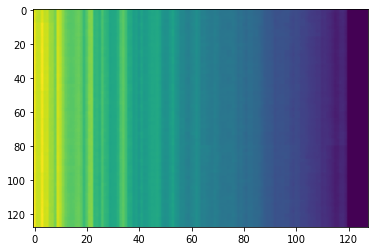

2020-11-18 03:16:58,557 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:0.017940, valid_AUC:0.486502, valid_pAUC:0.509922
100%|██████████| 1803/1803 [00:22<00:00, 78.43it/s]
2020-11-18 03:18:21,423 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:0.017899, valid_AUC:0.484460, valid_pAUC:0.509566
100%|██████████| 1803/1803 [00:22<00:00, 78.67it/s]
2020-11-18 03:19:44,257 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:0.017878, valid_AUC:0.488227, valid_pAUC:0.509866
100%|██████████| 1803/1803 [00:22<00:00, 78.96it/s]
2020-11-18 03:21:07,080 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:0.017883, valid_AUC:0.486030, valid_pAUC:0.509829
100%|██████████| 1803/1803 [00:22<00:00, 78.42it/s]
2020-11-18 03:22:29,994 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:0.017895, valid_AUC:0.485688, valid_pAUC:0.509350
100%|██████████| 1803/1803 [00:22<00:00, 78.61it/s]


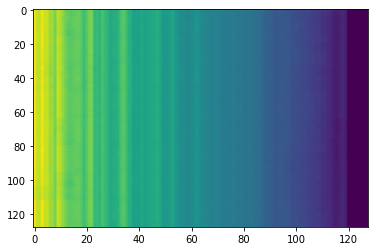

2020-11-18 03:23:52,948 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:0.017948, valid_AUC:0.487792, valid_pAUC:0.508881
100%|██████████| 1803/1803 [00:22<00:00, 79.00it/s]
2020-11-18 03:25:15,712 - pytorch_modeler.py - INFO - Epoch 46/100:train_loss:0.017815, valid_AUC:0.488790, valid_pAUC:0.508919
100%|██████████| 1803/1803 [00:22<00:00, 78.93it/s]
2020-11-18 03:26:38,473 - pytorch_modeler.py - INFO - Epoch 47/100:train_loss:0.017771, valid_AUC:0.488382, valid_pAUC:0.509397
100%|██████████| 1803/1803 [00:22<00:00, 78.61it/s]
2020-11-18 03:28:01,295 - pytorch_modeler.py - INFO - Epoch 48/100:train_loss:0.017738, valid_AUC:0.485763, valid_pAUC:0.509022
100%|██████████| 1803/1803 [00:22<00:00, 78.91it/s]
2020-11-18 03:29:24,115 - pytorch_modeler.py - INFO - Epoch 49/100:train_loss:0.017736, valid_AUC:0.481509, valid_pAUC:0.507465
100%|██████████| 1803/1803 [00:22<00:00, 78.86it/s]


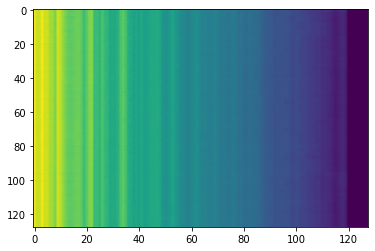

2020-11-18 03:30:46,961 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:0.017723, valid_AUC:0.487030, valid_pAUC:0.508666
100%|██████████| 1803/1803 [00:22<00:00, 78.61it/s]
2020-11-18 03:32:09,814 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:0.017740, valid_AUC:0.487712, valid_pAUC:0.510288
100%|██████████| 1803/1803 [00:22<00:00, 79.05it/s]
2020-11-18 03:33:32,507 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:0.017741, valid_AUC:0.486980, valid_pAUC:0.509425
100%|██████████| 1803/1803 [00:22<00:00, 78.66it/s]
2020-11-18 03:34:55,387 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:0.017730, valid_AUC:0.489300, valid_pAUC:0.509228
100%|██████████| 1803/1803 [00:23<00:00, 78.31it/s]
2020-11-18 03:36:18,316 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:0.017715, valid_AUC:0.489036, valid_pAUC:0.509453
100%|██████████| 1803/1803 [00:22<00:00, 79.09it/s]


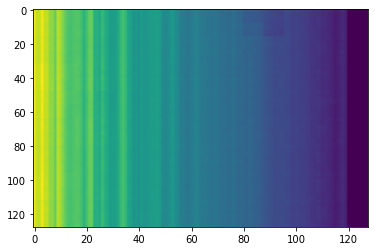

2020-11-18 03:37:41,084 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:0.017697, valid_AUC:0.480310, valid_pAUC:0.507803
100%|██████████| 1803/1803 [00:22<00:00, 78.57it/s]
2020-11-18 03:39:03,956 - pytorch_modeler.py - INFO - Epoch 56/100:train_loss:0.017712, valid_AUC:0.486021, valid_pAUC:0.509425
100%|██████████| 1803/1803 [00:22<00:00, 78.48it/s]
2020-11-18 03:40:26,829 - pytorch_modeler.py - INFO - Epoch 57/100:train_loss:0.017701, valid_AUC:0.484293, valid_pAUC:0.509847
100%|██████████| 1803/1803 [00:22<00:00, 79.14it/s]
2020-11-18 03:41:49,544 - pytorch_modeler.py - INFO - Epoch 58/100:train_loss:0.017705, valid_AUC:0.488995, valid_pAUC:0.508891
100%|██████████| 1803/1803 [00:22<00:00, 78.79it/s]
2020-11-18 03:43:12,366 - pytorch_modeler.py - INFO - Epoch 59/100:train_loss:0.017694, valid_AUC:0.484382, valid_pAUC:0.509303
100%|██████████| 1803/1803 [00:23<00:00, 78.28it/s]


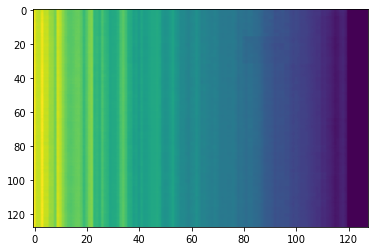

2020-11-18 03:44:35,428 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:0.017703, valid_AUC:0.486948, valid_pAUC:0.509519
100%|██████████| 1803/1803 [00:22<00:00, 79.01it/s]
2020-11-18 03:45:58,271 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:0.017697, valid_AUC:0.486520, valid_pAUC:0.509547
100%|██████████| 1803/1803 [00:22<00:00, 78.70it/s]
2020-11-18 03:47:21,102 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:0.017699, valid_AUC:0.485545, valid_pAUC:0.509829
100%|██████████| 1803/1803 [00:22<00:00, 78.59it/s]
2020-11-18 03:48:43,953 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:0.017699, valid_AUC:0.488209, valid_pAUC:0.509632
100%|██████████| 1803/1803 [00:22<00:00, 78.95it/s]
2020-11-18 03:50:06,735 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:0.017693, valid_AUC:0.484592, valid_pAUC:0.508506
100%|██████████| 1803/1803 [00:22<00:00, 78.91it/s]


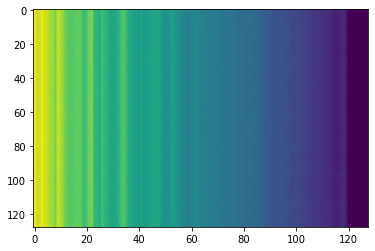

2020-11-18 03:51:29,601 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:0.017702, valid_AUC:0.484285, valid_pAUC:0.509416
100%|██████████| 1803/1803 [00:22<00:00, 78.69it/s]
2020-11-18 03:52:52,423 - pytorch_modeler.py - INFO - Epoch 66/100:train_loss:0.017713, valid_AUC:0.485490, valid_pAUC:0.509819
100%|██████████| 1803/1803 [00:22<00:00, 78.73it/s]
2020-11-18 03:54:15,200 - pytorch_modeler.py - INFO - Epoch 67/100:train_loss:0.017712, valid_AUC:0.486363, valid_pAUC:0.509679
100%|██████████| 1803/1803 [00:22<00:00, 78.84it/s]
2020-11-18 03:55:37,975 - pytorch_modeler.py - INFO - Epoch 68/100:train_loss:0.017703, valid_AUC:0.485233, valid_pAUC:0.509557
100%|██████████| 1803/1803 [00:22<00:00, 78.72it/s]
2020-11-18 03:57:00,763 - pytorch_modeler.py - INFO - Epoch 69/100:train_loss:0.017713, valid_AUC:0.485625, valid_pAUC:0.509707
100%|██████████| 1803/1803 [00:22<00:00, 78.54it/s]


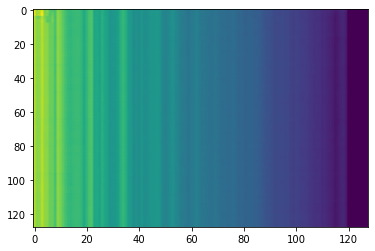

2020-11-18 03:58:23,759 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:0.017717, valid_AUC:0.484674, valid_pAUC:0.509632
100%|██████████| 1803/1803 [00:22<00:00, 78.81it/s]
2020-11-18 03:59:46,575 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:0.017729, valid_AUC:0.485542, valid_pAUC:0.509904
100%|██████████| 1803/1803 [00:22<00:00, 78.87it/s]
2020-11-18 04:01:09,304 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:0.017718, valid_AUC:0.486695, valid_pAUC:0.509660
100%|██████████| 1803/1803 [00:22<00:00, 78.54it/s]
2020-11-18 04:02:32,145 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:0.017716, valid_AUC:0.486326, valid_pAUC:0.509772
100%|██████████| 1803/1803 [00:22<00:00, 78.88it/s]
2020-11-18 04:03:54,930 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:0.017719, valid_AUC:0.486677, valid_pAUC:0.509754
100%|██████████| 1803/1803 [00:22<00:00, 78.66it/s]


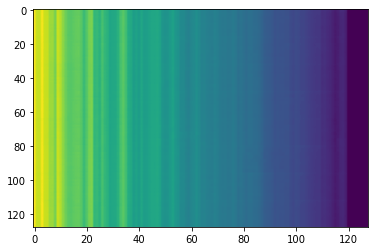

2020-11-18 04:05:17,839 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:0.017722, valid_AUC:0.486297, valid_pAUC:0.509810
100%|██████████| 1803/1803 [00:22<00:00, 78.85it/s]
2020-11-18 04:06:40,650 - pytorch_modeler.py - INFO - Epoch 76/100:train_loss:0.017725, valid_AUC:0.486896, valid_pAUC:0.509688
100%|██████████| 1803/1803 [00:22<00:00, 78.87it/s]
2020-11-18 04:08:03,385 - pytorch_modeler.py - INFO - Epoch 77/100:train_loss:0.017724, valid_AUC:0.485577, valid_pAUC:0.509979
100%|██████████| 1803/1803 [00:22<00:00, 78.78it/s]
2020-11-18 04:09:26,158 - pytorch_modeler.py - INFO - Epoch 78/100:train_loss:0.017729, valid_AUC:0.485285, valid_pAUC:0.509866
100%|██████████| 1803/1803 [00:22<00:00, 78.78it/s]
2020-11-18 04:10:48,975 - pytorch_modeler.py - INFO - Epoch 79/100:train_loss:0.017730, valid_AUC:0.485563, valid_pAUC:0.509707
100%|██████████| 1803/1803 [00:22<00:00, 78.76it/s]


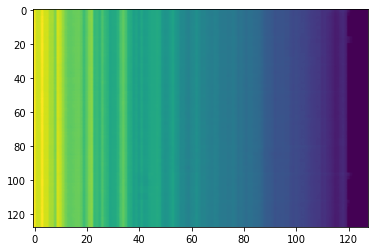

2020-11-18 04:12:11,889 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:0.017727, valid_AUC:0.486037, valid_pAUC:0.509782
100%|██████████| 1803/1803 [00:22<00:00, 78.68it/s]
2020-11-18 04:13:34,812 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:0.017734, valid_AUC:0.485560, valid_pAUC:0.509838
100%|██████████| 1803/1803 [00:22<00:00, 78.79it/s]
2020-11-18 04:14:57,586 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:0.017735, valid_AUC:0.486543, valid_pAUC:0.509763
100%|██████████| 1803/1803 [00:22<00:00, 78.52it/s]
2020-11-18 04:16:20,467 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:0.017735, valid_AUC:0.485682, valid_pAUC:0.509725
100%|██████████| 1803/1803 [00:22<00:00, 78.87it/s]
2020-11-18 04:17:43,171 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:0.017738, valid_AUC:0.485392, valid_pAUC:0.510101
100%|██████████| 1803/1803 [00:22<00:00, 78.58it/s]


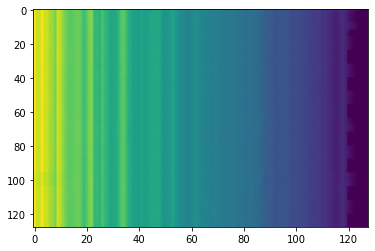

2020-11-18 04:19:06,099 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:0.017736, valid_AUC:0.486073, valid_pAUC:0.509829
100%|██████████| 1803/1803 [00:22<00:00, 78.45it/s]
2020-11-18 04:20:29,008 - pytorch_modeler.py - INFO - Epoch 86/100:train_loss:0.017741, valid_AUC:0.486454, valid_pAUC:0.509754
100%|██████████| 1803/1803 [00:22<00:00, 78.86it/s]
2020-11-18 04:21:51,801 - pytorch_modeler.py - INFO - Epoch 87/100:train_loss:0.017739, valid_AUC:0.485786, valid_pAUC:0.509707
100%|██████████| 1803/1803 [00:22<00:00, 78.79it/s]
2020-11-18 04:23:14,580 - pytorch_modeler.py - INFO - Epoch 88/100:train_loss:0.017745, valid_AUC:0.486226, valid_pAUC:0.509707
100%|██████████| 1803/1803 [00:22<00:00, 78.80it/s]
2020-11-18 04:24:37,390 - pytorch_modeler.py - INFO - Epoch 89/100:train_loss:0.017741, valid_AUC:0.486044, valid_pAUC:0.509735
100%|██████████| 1803/1803 [00:22<00:00, 79.00it/s]


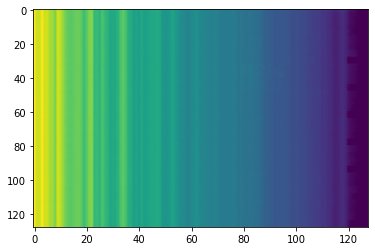

2020-11-18 04:26:00,228 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:0.017744, valid_AUC:0.485665, valid_pAUC:0.509782
100%|██████████| 1803/1803 [00:22<00:00, 78.81it/s]
2020-11-18 04:27:22,986 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:0.017744, valid_AUC:0.486140, valid_pAUC:0.509754
100%|██████████| 1803/1803 [00:22<00:00, 78.77it/s]
2020-11-18 04:28:45,817 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:0.017749, valid_AUC:0.486058, valid_pAUC:0.509754
100%|██████████| 1803/1803 [00:22<00:00, 78.89it/s]
2020-11-18 04:30:08,563 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:0.017748, valid_AUC:0.485919, valid_pAUC:0.509725
100%|██████████| 1803/1803 [00:22<00:00, 78.81it/s]
2020-11-18 04:31:31,319 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:0.017747, valid_AUC:0.486128, valid_pAUC:0.509697
100%|██████████| 1803/1803 [00:22<00:00, 78.72it/s]


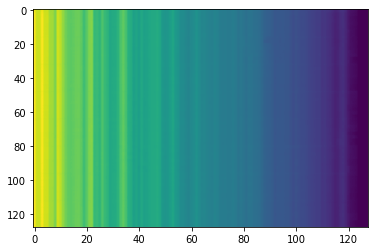

2020-11-18 04:32:54,193 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:0.017752, valid_AUC:0.486151, valid_pAUC:0.509800
100%|██████████| 1803/1803 [00:22<00:00, 78.61it/s]
2020-11-18 04:34:17,038 - pytorch_modeler.py - INFO - Epoch 96/100:train_loss:0.017752, valid_AUC:0.486099, valid_pAUC:0.509810
100%|██████████| 1803/1803 [00:22<00:00, 78.83it/s]
2020-11-18 04:35:39,806 - pytorch_modeler.py - INFO - Epoch 97/100:train_loss:0.017760, valid_AUC:0.486044, valid_pAUC:0.509725
100%|██████████| 1803/1803 [00:22<00:00, 78.70it/s]
2020-11-18 04:37:02,588 - pytorch_modeler.py - INFO - Epoch 98/100:train_loss:0.017765, valid_AUC:0.486000, valid_pAUC:0.509772
100%|██████████| 1803/1803 [00:22<00:00, 78.40it/s]
2020-11-18 04:38:25,498 - pytorch_modeler.py - INFO - Epoch 99/100:train_loss:0.017765, valid_AUC:0.486082, valid_pAUC:0.509716
100%|██████████| 1803/1803 [00:22<00:00, 78.76it/s]


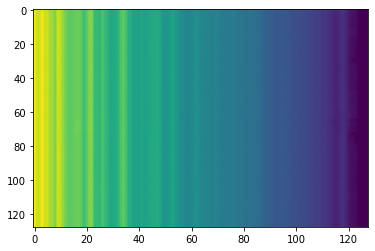

2020-11-18 04:39:48,377 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:0.017774, valid_AUC:0.486108, valid_pAUC:0.509763
2020-11-18 04:39:50,632 - 00_train.py - INFO - 
 success:fan 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_CONV_VAE2/models/fan_model.pth


elapsed time: 8315.324994326 [sec]


2020-11-18 04:39:52,728 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2020-11-18 04:39:52,728 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-18 04:39:52,730 - 00_train.py - INFO - TRAINING
  0%|          | 0/91 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 832/832 [00:14<00:00, 57.86it/s]


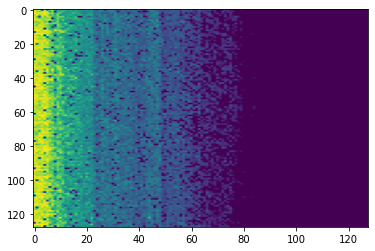

2020-11-18 04:42:00,131 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:0.044594, valid_AUC:0.569398, valid_pAUC:0.527930
100%|██████████| 832/832 [00:10<00:00, 78.14it/s]
2020-11-18 04:43:03,692 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:4155.731230, valid_AUC:0.537124, valid_pAUC:0.502741
100%|██████████| 832/832 [00:10<00:00, 78.04it/s]
2020-11-18 04:44:07,242 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:127.105545, valid_AUC:0.649034, valid_pAUC:0.514315
100%|██████████| 832/832 [00:10<00:00, 78.39it/s]
2020-11-18 04:45:10,973 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:0.860324, valid_AUC:0.568108, valid_pAUC:0.515716
100%|██████████| 832/832 [00:10<00:00, 77.80it/s]


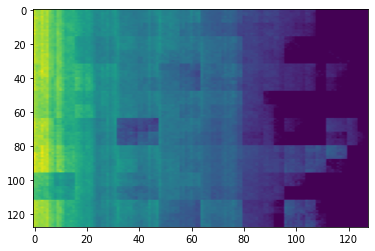

2020-11-18 04:46:14,805 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:0.633271, valid_AUC:0.518368, valid_pAUC:0.518884
100%|██████████| 832/832 [00:10<00:00, 80.04it/s]
2020-11-18 04:47:17,445 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.60it/s]
2020-11-18 04:48:20,187 - pytorch_modeler.py - INFO - Epoch 7/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.53it/s]
2020-11-18 04:49:22,774 - pytorch_modeler.py - INFO - Epoch 8/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 80.03it/s]
2020-11-18 04:50:25,329 - pytorch_modeler.py - INFO - Epoch 9/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.58it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

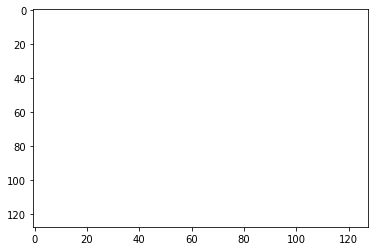

2020-11-18 04:51:28,015 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.68it/s]
2020-11-18 04:52:30,638 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.97it/s]
2020-11-18 04:53:33,103 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.14it/s]
2020-11-18 04:54:35,687 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.65it/s]
2020-11-18 04:55:38,179 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.82it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

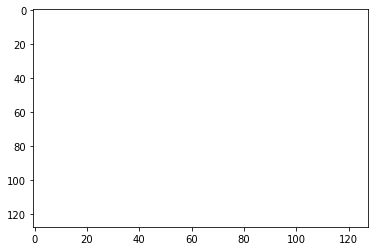

2020-11-18 04:56:40,757 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.62it/s]
2020-11-18 04:57:43,234 - pytorch_modeler.py - INFO - Epoch 16/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.75it/s]
2020-11-18 04:58:45,749 - pytorch_modeler.py - INFO - Epoch 17/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 80.02it/s]
2020-11-18 04:59:48,221 - pytorch_modeler.py - INFO - Epoch 18/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.36it/s]
2020-11-18 05:00:50,889 - pytorch_modeler.py - INFO - Epoch 19/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.85it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

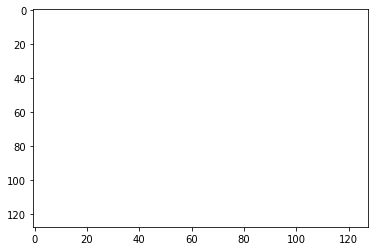

2020-11-18 05:01:53,445 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.86it/s]
2020-11-18 05:02:56,082 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.40it/s]
2020-11-18 05:03:58,618 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.72it/s]
2020-11-18 05:05:01,255 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.86it/s]
2020-11-18 05:06:03,710 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.98it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

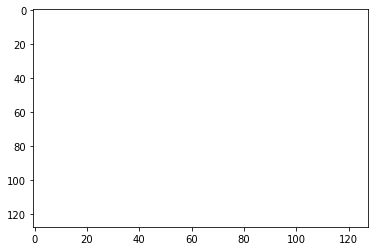

2020-11-18 05:07:06,279 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.73it/s]
2020-11-18 05:08:08,758 - pytorch_modeler.py - INFO - Epoch 26/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.62it/s]
2020-11-18 05:09:11,286 - pytorch_modeler.py - INFO - Epoch 27/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.36it/s]
2020-11-18 05:10:13,859 - pytorch_modeler.py - INFO - Epoch 28/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.98it/s]
2020-11-18 05:11:16,338 - pytorch_modeler.py - INFO - Epoch 29/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.64it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

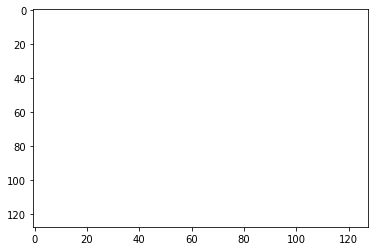

2020-11-18 05:12:19,061 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 80.08it/s]
2020-11-18 05:13:21,540 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.81it/s]
2020-11-18 05:14:24,008 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.52it/s]
2020-11-18 05:15:26,535 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.75it/s]
2020-11-18 05:16:29,033 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.68it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

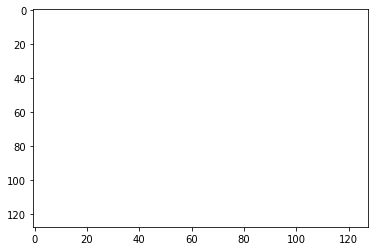

2020-11-18 05:17:31,644 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.39it/s]
2020-11-18 05:18:34,224 - pytorch_modeler.py - INFO - Epoch 36/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.46it/s]
2020-11-18 05:19:36,777 - pytorch_modeler.py - INFO - Epoch 37/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.82it/s]
2020-11-18 05:20:39,429 - pytorch_modeler.py - INFO - Epoch 38/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.73it/s]
2020-11-18 05:21:42,067 - pytorch_modeler.py - INFO - Epoch 39/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.71it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

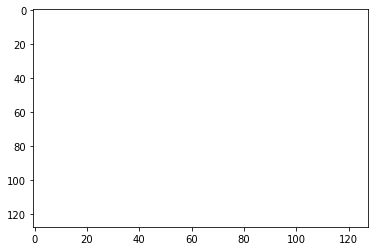

2020-11-18 05:22:44,676 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.34it/s]
2020-11-18 05:23:47,232 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.16it/s]
2020-11-18 05:24:49,839 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.60it/s]
2020-11-18 05:25:52,375 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.04it/s]
2020-11-18 05:26:55,030 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.74it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

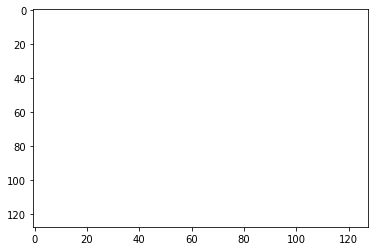

2020-11-18 05:27:57,741 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.72it/s]
2020-11-18 05:29:00,229 - pytorch_modeler.py - INFO - Epoch 46/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.31it/s]
2020-11-18 05:30:02,807 - pytorch_modeler.py - INFO - Epoch 47/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.24it/s]
2020-11-18 05:31:05,388 - pytorch_modeler.py - INFO - Epoch 48/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.41it/s]
2020-11-18 05:32:07,924 - pytorch_modeler.py - INFO - Epoch 49/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.80it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

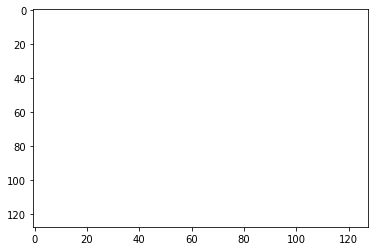

2020-11-18 05:33:10,702 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 77.79it/s]
2020-11-18 05:34:13,435 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.80it/s]
2020-11-18 05:35:16,064 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.00it/s]
2020-11-18 05:36:18,666 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.16it/s]
2020-11-18 05:37:21,225 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.05it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

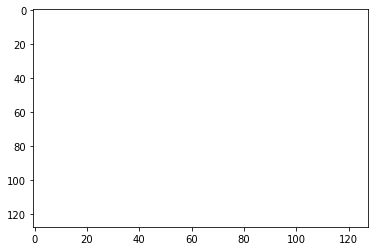

2020-11-18 05:38:23,962 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.64it/s]
2020-11-18 05:39:26,499 - pytorch_modeler.py - INFO - Epoch 56/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.26it/s]
2020-11-18 05:40:29,045 - pytorch_modeler.py - INFO - Epoch 57/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.74it/s]
2020-11-18 05:41:31,679 - pytorch_modeler.py - INFO - Epoch 58/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.76it/s]
2020-11-18 05:42:34,150 - pytorch_modeler.py - INFO - Epoch 59/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.30it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

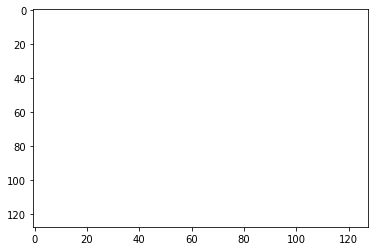

2020-11-18 05:43:36,794 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.84it/s]
2020-11-18 05:44:39,417 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.65it/s]
2020-11-18 05:45:41,956 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.43it/s]
2020-11-18 05:46:44,590 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.69it/s]
2020-11-18 05:47:47,256 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.70it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

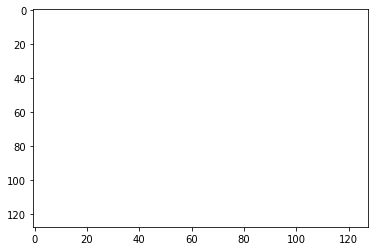

2020-11-18 05:48:49,829 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.23it/s]
2020-11-18 05:49:52,420 - pytorch_modeler.py - INFO - Epoch 66/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.65it/s]
2020-11-18 05:50:55,077 - pytorch_modeler.py - INFO - Epoch 67/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.54it/s]
2020-11-18 05:51:57,595 - pytorch_modeler.py - INFO - Epoch 68/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.35it/s]
2020-11-18 05:53:00,144 - pytorch_modeler.py - INFO - Epoch 69/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.53it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

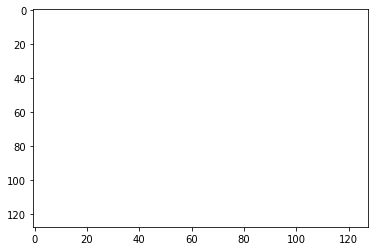

2020-11-18 05:54:02,893 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 80.05it/s]
2020-11-18 05:55:05,330 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.46it/s]
2020-11-18 05:56:07,846 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.15it/s]
2020-11-18 05:57:10,526 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.25it/s]
2020-11-18 05:58:13,109 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.66it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

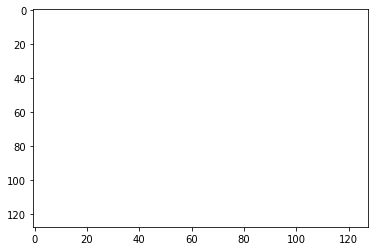

2020-11-18 05:59:15,679 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.37it/s]
2020-11-18 06:00:18,361 - pytorch_modeler.py - INFO - Epoch 76/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.77it/s]
2020-11-18 06:01:20,860 - pytorch_modeler.py - INFO - Epoch 77/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.50it/s]
2020-11-18 06:02:23,373 - pytorch_modeler.py - INFO - Epoch 78/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.13it/s]
2020-11-18 06:03:25,921 - pytorch_modeler.py - INFO - Epoch 79/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.97it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

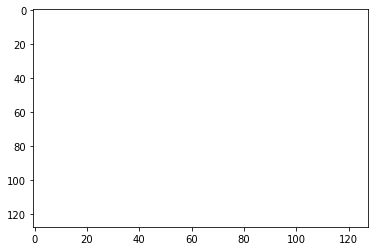

2020-11-18 06:04:28,514 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.51it/s]
2020-11-18 06:05:31,030 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.90it/s]
2020-11-18 06:06:33,672 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.90it/s]
2020-11-18 06:07:36,138 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.41it/s]
2020-11-18 06:08:38,760 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.10it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

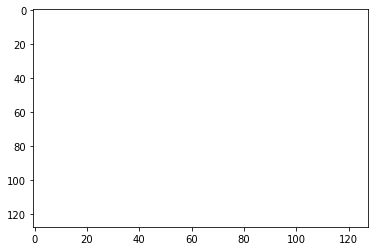

2020-11-18 06:09:41,433 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.76it/s]
2020-11-18 06:10:43,931 - pytorch_modeler.py - INFO - Epoch 86/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.32it/s]
2020-11-18 06:11:46,458 - pytorch_modeler.py - INFO - Epoch 87/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.89it/s]
2020-11-18 06:12:49,052 - pytorch_modeler.py - INFO - Epoch 88/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.90it/s]
2020-11-18 06:13:51,481 - pytorch_modeler.py - INFO - Epoch 89/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.32it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

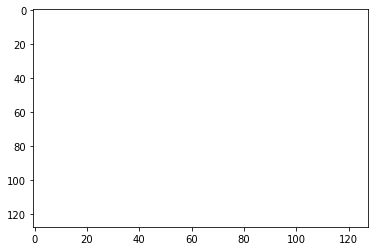

2020-11-18 06:14:54,134 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.13it/s]
2020-11-18 06:15:56,703 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.87it/s]
2020-11-18 06:16:59,189 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.47it/s]
2020-11-18 06:18:01,720 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.77it/s]
2020-11-18 06:19:04,339 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.93it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

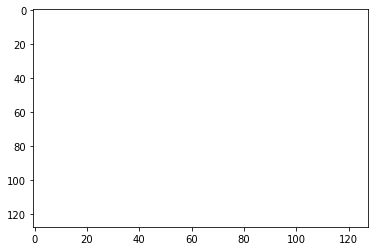

2020-11-18 06:20:06,889 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.55it/s]
2020-11-18 06:21:09,409 - pytorch_modeler.py - INFO - Epoch 96/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.05it/s]
2020-11-18 06:22:12,014 - pytorch_modeler.py - INFO - Epoch 97/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 79.79it/s]
2020-11-18 06:23:14,556 - pytorch_modeler.py - INFO - Epoch 98/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.57it/s]
2020-11-18 06:24:17,207 - pytorch_modeler.py - INFO - Epoch 99/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 832/832 [00:10<00:00, 78.84it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
 

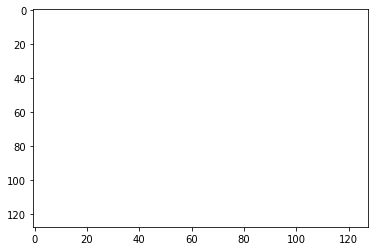

2020-11-18 06:25:19,937 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
2020-11-18 06:25:22,189 - 00_train.py - INFO - 
 success:pump 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_CONV_VAE2/models/pump_model.pth


elapsed time: 6329.462779045 [sec]


2020-11-18 06:25:24,387 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2020-11-18 06:25:24,388 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-18 06:25:24,389 - 00_train.py - INFO - TRAINING
  0%|          | 0/81 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 1246/1246 [00:21<00:00, 58.31it/s]


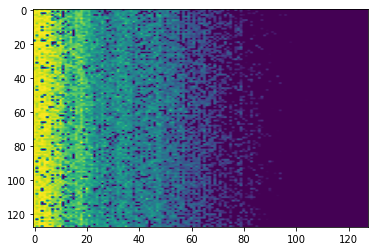

2020-11-18 06:27:24,558 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:0.048519, valid_AUC:0.324455, valid_pAUC:0.482612
100%|██████████| 1246/1246 [00:15<00:00, 78.76it/s]
2020-11-18 06:28:27,846 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:6325.461688, valid_AUC:0.636856, valid_pAUC:0.529038
100%|██████████| 1246/1246 [00:15<00:00, 79.22it/s]
2020-11-18 06:29:31,022 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:559.476596, valid_AUC:0.508026, valid_pAUC:0.532941
100%|██████████| 1246/1246 [00:15<00:00, 79.22it/s]
2020-11-18 06:30:34,149 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:0.947318, valid_AUC:0.510765, valid_pAUC:0.521012
100%|██████████| 1246/1246 [00:15<00:00, 79.33it/s]


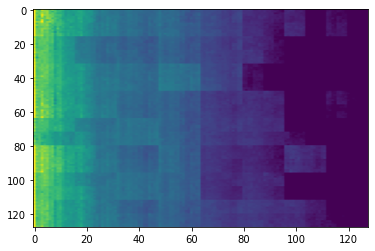

2020-11-18 06:31:37,479 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:0.274634, valid_AUC:0.661348, valid_pAUC:0.544466
100%|██████████| 1246/1246 [00:15<00:00, 79.08it/s]
2020-11-18 06:32:40,671 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:0.159959, valid_AUC:0.670556, valid_pAUC:0.539863
100%|██████████| 1246/1246 [00:15<00:00, 79.26it/s]
2020-11-18 06:33:43,829 - pytorch_modeler.py - INFO - Epoch 7/100:train_loss:0.117889, valid_AUC:0.644480, valid_pAUC:0.535508
100%|██████████| 1246/1246 [00:15<00:00, 79.16it/s]
2020-11-18 06:34:47,124 - pytorch_modeler.py - INFO - Epoch 8/100:train_loss:0.064529, valid_AUC:0.625727, valid_pAUC:0.531277
100%|██████████| 1246/1246 [00:15<00:00, 78.98it/s]
2020-11-18 06:35:50,335 - pytorch_modeler.py - INFO - Epoch 9/100:train_loss:0.050032, valid_AUC:0.623153, valid_pAUC:0.524760
100%|██████████| 1246/1246 [00:15<00:00, 78.84it/s]


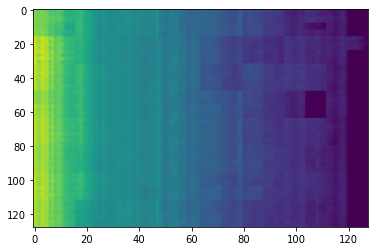

2020-11-18 06:36:53,709 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:0.043571, valid_AUC:0.623954, valid_pAUC:0.526082
100%|██████████| 1246/1246 [00:15<00:00, 79.47it/s]
2020-11-18 06:37:56,865 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:0.037224, valid_AUC:0.627837, valid_pAUC:0.527156
100%|██████████| 1246/1246 [00:15<00:00, 79.11it/s]
2020-11-18 06:39:00,058 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:0.034007, valid_AUC:0.622837, valid_pAUC:0.522459
100%|██████████| 1246/1246 [00:15<00:00, 79.31it/s]
2020-11-18 06:40:03,202 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:0.031685, valid_AUC:0.615683, valid_pAUC:0.518710
100%|██████████| 1246/1246 [00:15<00:00, 79.06it/s]
2020-11-18 06:41:06,438 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:0.029520, valid_AUC:0.610417, valid_pAUC:0.519410
100%|██████████| 1246/1246 [00:15<00:00, 79.11it/s]


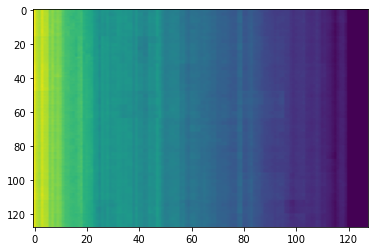

2020-11-18 06:42:09,729 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:0.028173, valid_AUC:0.618227, valid_pAUC:0.522008
100%|██████████| 1246/1246 [00:15<00:00, 79.07it/s]
2020-11-18 06:43:12,911 - pytorch_modeler.py - INFO - Epoch 16/100:train_loss:0.027623, valid_AUC:0.622172, valid_pAUC:0.517591
100%|██████████| 1246/1246 [00:15<00:00, 78.45it/s]
2020-11-18 06:44:16,212 - pytorch_modeler.py - INFO - Epoch 17/100:train_loss:0.025775, valid_AUC:0.610420, valid_pAUC:0.519177
100%|██████████| 1246/1246 [00:15<00:00, 79.11it/s]
2020-11-18 06:45:19,400 - pytorch_modeler.py - INFO - Epoch 18/100:train_loss:0.025160, valid_AUC:0.617668, valid_pAUC:0.519690
100%|██████████| 1246/1246 [00:15<00:00, 78.76it/s]
2020-11-18 06:46:22,612 - pytorch_modeler.py - INFO - Epoch 19/100:train_loss:0.024369, valid_AUC:0.613652, valid_pAUC:0.516206
100%|██████████| 1246/1246 [00:15<00:00, 79.06it/s]


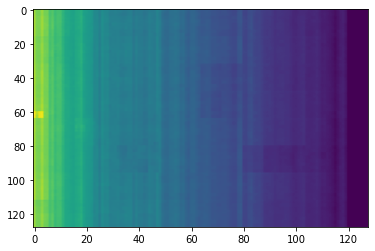

2020-11-18 06:47:25,916 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:0.023864, valid_AUC:0.604359, valid_pAUC:0.518570
100%|██████████| 1246/1246 [00:15<00:00, 79.37it/s]
2020-11-18 06:48:29,030 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:0.023215, valid_AUC:0.617411, valid_pAUC:0.515880
100%|██████████| 1246/1246 [00:16<00:00, 77.78it/s]
2020-11-18 06:49:32,528 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:0.022561, valid_AUC:0.616566, valid_pAUC:0.515211
100%|██████████| 1246/1246 [00:15<00:00, 79.15it/s]
2020-11-18 06:50:35,702 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:0.022146, valid_AUC:0.610786, valid_pAUC:0.515320
100%|██████████| 1246/1246 [00:15<00:00, 79.26it/s]
2020-11-18 06:51:38,862 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:0.021624, valid_AUC:0.617707, valid_pAUC:0.519317
100%|██████████| 1246/1246 [00:15<00:00, 79.26it/s]


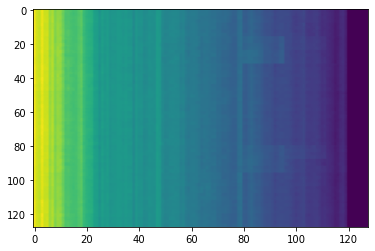

2020-11-18 06:52:42,153 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:0.021171, valid_AUC:0.613747, valid_pAUC:0.513578
100%|██████████| 1246/1246 [00:15<00:00, 79.28it/s]
2020-11-18 06:53:45,371 - pytorch_modeler.py - INFO - Epoch 26/100:train_loss:0.020969, valid_AUC:0.616755, valid_pAUC:0.517762
100%|██████████| 1246/1246 [00:15<00:00, 79.20it/s]
2020-11-18 06:54:48,540 - pytorch_modeler.py - INFO - Epoch 27/100:train_loss:0.020817, valid_AUC:0.616365, valid_pAUC:0.512287
100%|██████████| 1246/1246 [00:15<00:00, 79.19it/s]
2020-11-18 06:55:51,724 - pytorch_modeler.py - INFO - Epoch 28/100:train_loss:0.020740, valid_AUC:0.616262, valid_pAUC:0.514449
100%|██████████| 1246/1246 [00:15<00:00, 78.84it/s]
2020-11-18 06:56:54,963 - pytorch_modeler.py - INFO - Epoch 29/100:train_loss:0.020673, valid_AUC:0.616423, valid_pAUC:0.515895
100%|██████████| 1246/1246 [00:15<00:00, 79.01it/s]


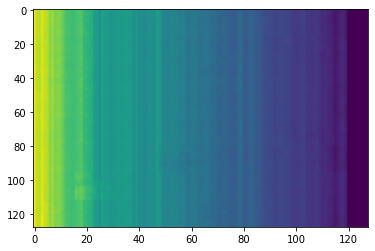

2020-11-18 06:57:58,247 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:0.020595, valid_AUC:0.615689, valid_pAUC:0.516844
100%|██████████| 1246/1246 [00:15<00:00, 79.10it/s]
2020-11-18 06:59:01,499 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:0.020578, valid_AUC:0.615573, valid_pAUC:0.515149
100%|██████████| 1246/1246 [00:15<00:00, 79.00it/s]
2020-11-18 07:00:04,701 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:0.020498, valid_AUC:0.610807, valid_pAUC:0.518244
100%|██████████| 1246/1246 [00:15<00:00, 79.25it/s]
2020-11-18 07:01:07,851 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:0.020472, valid_AUC:0.610724, valid_pAUC:0.516642
100%|██████████| 1246/1246 [00:15<00:00, 79.20it/s]
2020-11-18 07:02:11,057 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:0.020444, valid_AUC:0.615437, valid_pAUC:0.513267
100%|██████████| 1246/1246 [00:15<00:00, 79.03it/s]


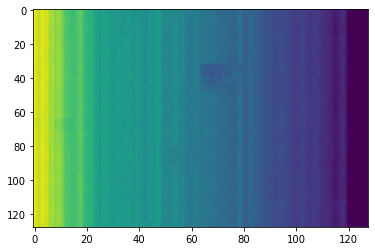

2020-11-18 07:03:14,376 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:0.020423, valid_AUC:0.612837, valid_pAUC:0.513951
100%|██████████| 1246/1246 [00:15<00:00, 78.39it/s]
2020-11-18 07:04:17,760 - pytorch_modeler.py - INFO - Epoch 36/100:train_loss:0.020379, valid_AUC:0.607515, valid_pAUC:0.517279
100%|██████████| 1246/1246 [00:15<00:00, 78.69it/s]
2020-11-18 07:05:21,007 - pytorch_modeler.py - INFO - Epoch 37/100:train_loss:0.020370, valid_AUC:0.615180, valid_pAUC:0.514775
100%|██████████| 1246/1246 [00:15<00:00, 78.52it/s]
2020-11-18 07:06:24,381 - pytorch_modeler.py - INFO - Epoch 38/100:train_loss:0.020367, valid_AUC:0.612048, valid_pAUC:0.515817
100%|██████████| 1246/1246 [00:15<00:00, 79.14it/s]
2020-11-18 07:07:27,595 - pytorch_modeler.py - INFO - Epoch 39/100:train_loss:0.020337, valid_AUC:0.611138, valid_pAUC:0.517839
100%|██████████| 1246/1246 [00:15<00:00, 79.26it/s]


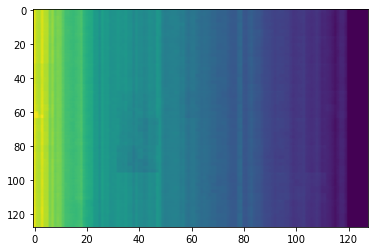

2020-11-18 07:08:30,863 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:0.020340, valid_AUC:0.614048, valid_pAUC:0.518384
100%|██████████| 1246/1246 [00:15<00:00, 79.28it/s]
2020-11-18 07:09:34,025 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:0.020370, valid_AUC:0.615168, valid_pAUC:0.515398
100%|██████████| 1246/1246 [00:15<00:00, 79.09it/s]
2020-11-18 07:10:37,219 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:0.020321, valid_AUC:0.606941, valid_pAUC:0.516331
100%|██████████| 1246/1246 [00:15<00:00, 79.30it/s]
2020-11-18 07:11:40,383 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:0.020333, valid_AUC:0.611847, valid_pAUC:0.517591
100%|██████████| 1246/1246 [00:15<00:00, 79.11it/s]
2020-11-18 07:12:43,575 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:0.020325, valid_AUC:0.609146, valid_pAUC:0.517466
100%|██████████| 1246/1246 [00:15<00:00, 79.09it/s]


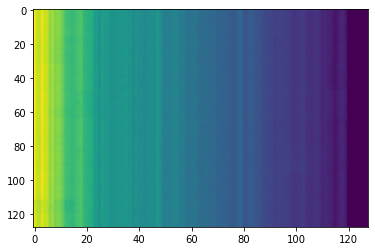

2020-11-18 07:13:46,871 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:0.020319, valid_AUC:0.607110, valid_pAUC:0.516782
100%|██████████| 1246/1246 [00:15<00:00, 79.14it/s]
2020-11-18 07:14:50,085 - pytorch_modeler.py - INFO - Epoch 46/100:train_loss:0.020320, valid_AUC:0.614504, valid_pAUC:0.514807
100%|██████████| 1246/1246 [00:15<00:00, 79.48it/s]
2020-11-18 07:15:53,193 - pytorch_modeler.py - INFO - Epoch 47/100:train_loss:0.020324, valid_AUC:0.617221, valid_pAUC:0.517948
100%|██████████| 1246/1246 [00:15<00:00, 78.93it/s]
2020-11-18 07:16:56,494 - pytorch_modeler.py - INFO - Epoch 48/100:train_loss:0.020326, valid_AUC:0.614601, valid_pAUC:0.514402
100%|██████████| 1246/1246 [00:15<00:00, 79.28it/s]
2020-11-18 07:17:59,623 - pytorch_modeler.py - INFO - Epoch 49/100:train_loss:0.020308, valid_AUC:0.608401, valid_pAUC:0.516611
100%|██████████| 1246/1246 [00:15<00:00, 79.32it/s]


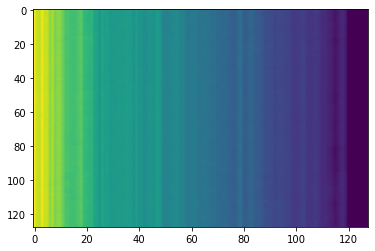

2020-11-18 07:19:03,039 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:0.020308, valid_AUC:0.614158, valid_pAUC:0.516066
100%|██████████| 1246/1246 [00:15<00:00, 79.14it/s]
2020-11-18 07:20:06,223 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:0.020309, valid_AUC:0.617683, valid_pAUC:0.514278
100%|██████████| 1246/1246 [00:15<00:00, 79.43it/s]
2020-11-18 07:21:09,332 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:0.020302, valid_AUC:0.611752, valid_pAUC:0.516720
100%|██████████| 1246/1246 [00:15<00:00, 78.42it/s]
2020-11-18 07:22:12,674 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:0.020316, valid_AUC:0.616466, valid_pAUC:0.513811
100%|██████████| 1246/1246 [00:15<00:00, 79.37it/s]
2020-11-18 07:23:15,791 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:0.020344, valid_AUC:0.612125, valid_pAUC:0.517404
100%|██████████| 1246/1246 [00:15<00:00, 78.55it/s]


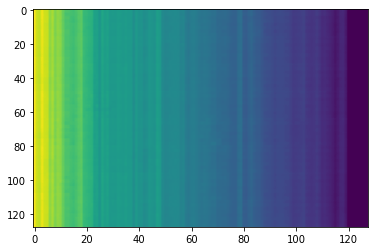

2020-11-18 07:24:19,202 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:0.020295, valid_AUC:0.614320, valid_pAUC:0.514262
100%|██████████| 1246/1246 [00:15<00:00, 79.07it/s]
2020-11-18 07:25:22,338 - pytorch_modeler.py - INFO - Epoch 56/100:train_loss:0.020315, valid_AUC:0.614713, valid_pAUC:0.515242
100%|██████████| 1246/1246 [00:15<00:00, 78.63it/s]
2020-11-18 07:26:25,618 - pytorch_modeler.py - INFO - Epoch 57/100:train_loss:0.020310, valid_AUC:0.616339, valid_pAUC:0.514122
100%|██████████| 1246/1246 [00:15<00:00, 79.18it/s]
2020-11-18 07:27:28,777 - pytorch_modeler.py - INFO - Epoch 58/100:train_loss:0.020342, valid_AUC:0.612840, valid_pAUC:0.518306
100%|██████████| 1246/1246 [00:15<00:00, 79.32it/s]
2020-11-18 07:28:31,893 - pytorch_modeler.py - INFO - Epoch 59/100:train_loss:0.020306, valid_AUC:0.606368, valid_pAUC:0.516300
100%|██████████| 1246/1246 [00:15<00:00, 79.13it/s]


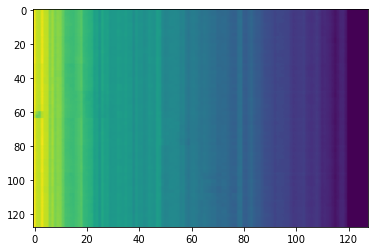

2020-11-18 07:29:35,250 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:0.020312, valid_AUC:0.616358, valid_pAUC:0.514076
100%|██████████| 1246/1246 [00:15<00:00, 79.26it/s]
2020-11-18 07:30:38,413 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:0.020312, valid_AUC:0.611014, valid_pAUC:0.517171
100%|██████████| 1246/1246 [00:15<00:00, 78.82it/s]
2020-11-18 07:31:41,653 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:0.020315, valid_AUC:0.614897, valid_pAUC:0.514807
100%|██████████| 1246/1246 [00:15<00:00, 79.32it/s]
2020-11-18 07:32:44,789 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:0.020312, valid_AUC:0.615774, valid_pAUC:0.515429
100%|██████████| 1246/1246 [00:15<00:00, 79.21it/s]
2020-11-18 07:33:47,977 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:0.020327, valid_AUC:0.613094, valid_pAUC:0.517031
100%|██████████| 1246/1246 [00:15<00:00, 79.21it/s]


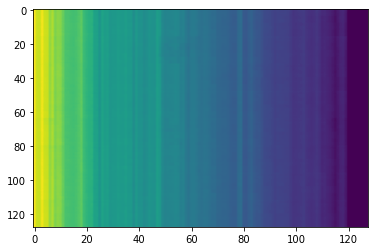

2020-11-18 07:34:51,278 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:0.020330, valid_AUC:0.613561, valid_pAUC:0.517186
100%|██████████| 1246/1246 [00:15<00:00, 79.34it/s]
2020-11-18 07:35:54,432 - pytorch_modeler.py - INFO - Epoch 66/100:train_loss:0.020314, valid_AUC:0.615366, valid_pAUC:0.517419
100%|██████████| 1246/1246 [00:15<00:00, 79.45it/s]
2020-11-18 07:36:57,586 - pytorch_modeler.py - INFO - Epoch 67/100:train_loss:0.020330, valid_AUC:0.611930, valid_pAUC:0.516626
100%|██████████| 1246/1246 [00:15<00:00, 79.02it/s]
2020-11-18 07:38:00,810 - pytorch_modeler.py - INFO - Epoch 68/100:train_loss:0.020544, valid_AUC:0.617408, valid_pAUC:0.516051
100%|██████████| 1246/1246 [00:15<00:00, 78.92it/s]
2020-11-18 07:39:04,149 - pytorch_modeler.py - INFO - Epoch 69/100:train_loss:0.020330, valid_AUC:0.615325, valid_pAUC:0.516160
100%|██████████| 1246/1246 [00:15<00:00, 79.12it/s]


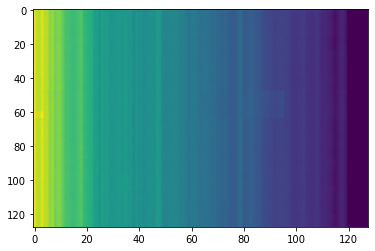

2020-11-18 07:40:07,444 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:0.020338, valid_AUC:0.616020, valid_pAUC:0.516611
100%|██████████| 1246/1246 [00:15<00:00, 79.21it/s]
2020-11-18 07:41:10,618 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:0.020342, valid_AUC:0.614758, valid_pAUC:0.515724
100%|██████████| 1246/1246 [00:15<00:00, 78.48it/s]
2020-11-18 07:42:13,910 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:0.020327, valid_AUC:0.613490, valid_pAUC:0.517622
100%|██████████| 1246/1246 [00:15<00:00, 78.97it/s]
2020-11-18 07:43:17,150 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:0.020343, valid_AUC:0.611995, valid_pAUC:0.517342
100%|██████████| 1246/1246 [00:15<00:00, 78.33it/s]
2020-11-18 07:44:20,496 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:0.020340, valid_AUC:0.614375, valid_pAUC:0.517575
100%|██████████| 1246/1246 [00:15<00:00, 79.07it/s]


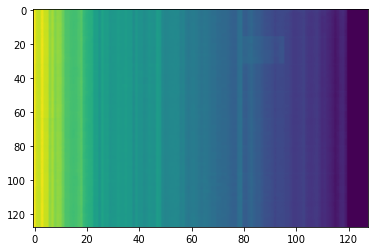

2020-11-18 07:45:23,785 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:0.020338, valid_AUC:0.614518, valid_pAUC:0.514900
100%|██████████| 1246/1246 [00:15<00:00, 78.69it/s]
2020-11-18 07:46:27,075 - pytorch_modeler.py - INFO - Epoch 76/100:train_loss:0.020346, valid_AUC:0.615783, valid_pAUC:0.514869
100%|██████████| 1246/1246 [00:15<00:00, 78.83it/s]
2020-11-18 07:47:30,311 - pytorch_modeler.py - INFO - Epoch 77/100:train_loss:0.020351, valid_AUC:0.616150, valid_pAUC:0.516129
100%|██████████| 1246/1246 [00:15<00:00, 78.95it/s]
2020-11-18 07:48:33,633 - pytorch_modeler.py - INFO - Epoch 78/100:train_loss:0.020342, valid_AUC:0.611401, valid_pAUC:0.517202
100%|██████████| 1246/1246 [00:15<00:00, 79.28it/s]
2020-11-18 07:49:36,767 - pytorch_modeler.py - INFO - Epoch 79/100:train_loss:0.020349, valid_AUC:0.613975, valid_pAUC:0.517155
100%|██████████| 1246/1246 [00:15<00:00, 79.09it/s]


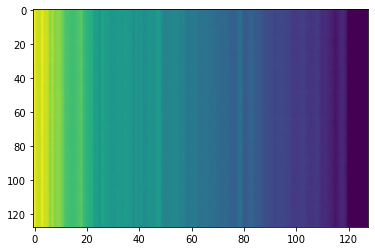

2020-11-18 07:50:40,165 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:0.020354, valid_AUC:0.613180, valid_pAUC:0.514993
100%|██████████| 1246/1246 [00:15<00:00, 79.22it/s]
2020-11-18 07:51:43,323 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:0.020353, valid_AUC:0.614057, valid_pAUC:0.516688
100%|██████████| 1246/1246 [00:15<00:00, 78.91it/s]
2020-11-18 07:52:46,581 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:0.020360, valid_AUC:0.613641, valid_pAUC:0.517186
100%|██████████| 1246/1246 [00:15<00:00, 79.01it/s]
2020-11-18 07:53:49,787 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:0.020365, valid_AUC:0.614935, valid_pAUC:0.516160
100%|██████████| 1246/1246 [00:15<00:00, 79.09it/s]
2020-11-18 07:54:53,022 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:0.020361, valid_AUC:0.614415, valid_pAUC:0.516813
100%|██████████| 1246/1246 [00:15<00:00, 79.22it/s]


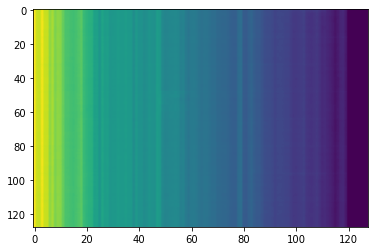

2020-11-18 07:55:56,274 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:0.020370, valid_AUC:0.613667, valid_pAUC:0.516580
100%|██████████| 1246/1246 [00:15<00:00, 79.45it/s]
2020-11-18 07:56:59,424 - pytorch_modeler.py - INFO - Epoch 86/100:train_loss:0.020366, valid_AUC:0.613868, valid_pAUC:0.516533
100%|██████████| 1246/1246 [00:15<00:00, 79.15it/s]
2020-11-18 07:58:02,606 - pytorch_modeler.py - INFO - Epoch 87/100:train_loss:0.020380, valid_AUC:0.613274, valid_pAUC:0.516828
100%|██████████| 1246/1246 [00:15<00:00, 79.15it/s]
2020-11-18 07:59:05,892 - pytorch_modeler.py - INFO - Epoch 88/100:train_loss:0.020385, valid_AUC:0.614846, valid_pAUC:0.515693
100%|██████████| 1246/1246 [00:15<00:00, 79.13it/s]
2020-11-18 08:00:09,073 - pytorch_modeler.py - INFO - Epoch 89/100:train_loss:0.020378, valid_AUC:0.612813, valid_pAUC:0.516735
100%|██████████| 1246/1246 [00:15<00:00, 79.17it/s]


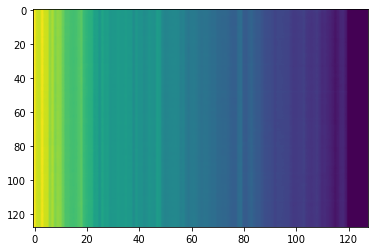

2020-11-18 08:01:12,437 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:0.020383, valid_AUC:0.613392, valid_pAUC:0.516377
100%|██████████| 1246/1246 [00:15<00:00, 78.38it/s]
2020-11-18 08:02:15,779 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:0.020389, valid_AUC:0.613259, valid_pAUC:0.516346
100%|██████████| 1246/1246 [00:15<00:00, 78.93it/s]
2020-11-18 08:03:19,038 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:0.020391, valid_AUC:0.613585, valid_pAUC:0.516206
100%|██████████| 1246/1246 [00:15<00:00, 78.85it/s]
2020-11-18 08:04:22,272 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:0.020389, valid_AUC:0.613531, valid_pAUC:0.516471
100%|██████████| 1246/1246 [00:15<00:00, 79.00it/s]
2020-11-18 08:05:25,548 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:0.020389, valid_AUC:0.613655, valid_pAUC:0.516331
100%|██████████| 1246/1246 [00:15<00:00, 79.23it/s]


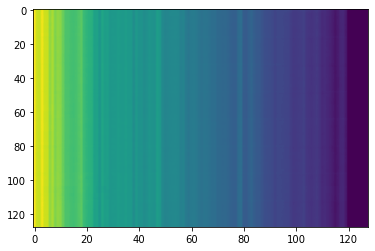

2020-11-18 08:06:28,797 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:0.020398, valid_AUC:0.614196, valid_pAUC:0.516160
100%|██████████| 1246/1246 [00:15<00:00, 79.70it/s]
2020-11-18 08:07:31,950 - pytorch_modeler.py - INFO - Epoch 96/100:train_loss:0.020402, valid_AUC:0.613945, valid_pAUC:0.516284
100%|██████████| 1246/1246 [00:15<00:00, 79.28it/s]
2020-11-18 08:08:35,141 - pytorch_modeler.py - INFO - Epoch 97/100:train_loss:0.020397, valid_AUC:0.613794, valid_pAUC:0.516377
100%|██████████| 1246/1246 [00:15<00:00, 78.79it/s]
2020-11-18 08:09:38,428 - pytorch_modeler.py - INFO - Epoch 98/100:train_loss:0.020406, valid_AUC:0.613913, valid_pAUC:0.516502
100%|██████████| 1246/1246 [00:15<00:00, 79.12it/s]
2020-11-18 08:10:41,607 - pytorch_modeler.py - INFO - Epoch 99/100:train_loss:0.020411, valid_AUC:0.613960, valid_pAUC:0.516377
100%|██████████| 1246/1246 [00:15<00:00, 79.14it/s]


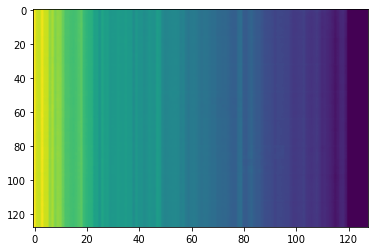

2020-11-18 08:11:44,883 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:0.020414, valid_AUC:0.614031, valid_pAUC:0.516424
2020-11-18 08:11:47,113 - 00_train.py - INFO - 
 success:slider 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_CONV_VAE2/models/slider_model.pth


elapsed time: 6382.726894379 [sec]


2020-11-18 08:11:49,187 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2020-11-18 08:11:49,188 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-18 08:11:49,190 - 00_train.py - INFO - TRAINING
  0%|          | 0/110 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 2407/2407 [00:43<00:00, 55.05it/s]


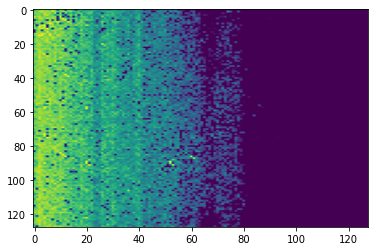

2020-11-18 08:14:51,981 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:0.034860, valid_AUC:0.319586, valid_pAUC:0.487803
100%|██████████| 2407/2407 [00:31<00:00, 77.47it/s]
2020-11-18 08:16:27,536 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:4058.871992, valid_AUC:0.352152, valid_pAUC:0.495038
100%|██████████| 2407/2407 [00:30<00:00, 77.97it/s]
2020-11-18 08:18:03,087 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:7760942544540838760808448.000000, valid_AUC:0.391712, valid_pAUC:0.519779
100%|██████████| 2407/2407 [00:30<00:00, 78.58it/s]
2020-11-18 08:19:37,726 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.63it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/ima

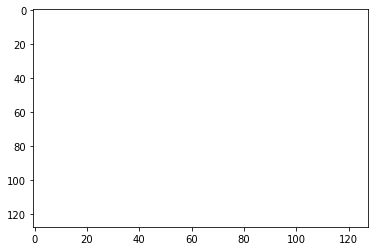

2020-11-18 08:21:12,119 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.93it/s]
2020-11-18 08:22:46,200 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.37it/s]
2020-11-18 08:24:20,501 - pytorch_modeler.py - INFO - Epoch 7/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.78it/s]
2020-11-18 08:25:54,672 - pytorch_modeler.py - INFO - Epoch 8/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.84it/s]
2020-11-18 08:27:28,833 - pytorch_modeler.py - INFO - Epoch 9/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.77it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to n

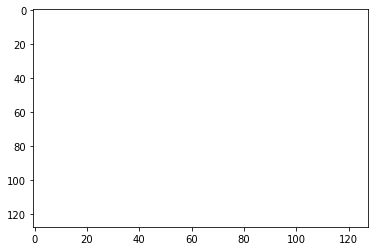

2020-11-18 08:29:03,109 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.37it/s]
2020-11-18 08:30:37,412 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.76it/s]
2020-11-18 08:32:11,531 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.31it/s]
2020-11-18 08:33:45,493 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.95it/s]
2020-11-18 08:35:19,608 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.67it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

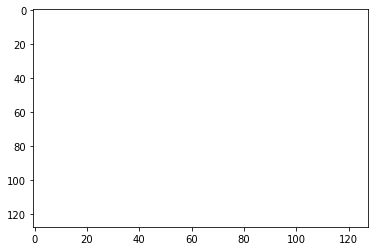

2020-11-18 08:36:53,909 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.75it/s]
2020-11-18 08:38:28,033 - pytorch_modeler.py - INFO - Epoch 16/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.68it/s]
2020-11-18 08:40:02,268 - pytorch_modeler.py - INFO - Epoch 17/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.59it/s]
2020-11-18 08:41:36,492 - pytorch_modeler.py - INFO - Epoch 18/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.77it/s]
2020-11-18 08:43:10,647 - pytorch_modeler.py - INFO - Epoch 19/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.29it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

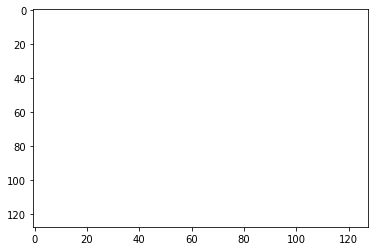

2020-11-18 08:44:45,176 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.81it/s]
2020-11-18 08:46:19,308 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.54it/s]
2020-11-18 08:47:53,616 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.45it/s]
2020-11-18 08:49:27,936 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.97it/s]
2020-11-18 08:51:02,039 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.14it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

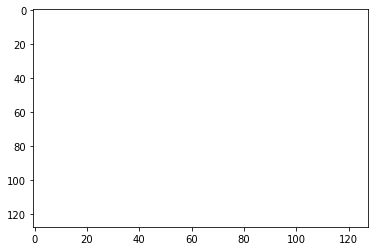

2020-11-18 08:52:36,589 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.00it/s]
2020-11-18 08:54:10,661 - pytorch_modeler.py - INFO - Epoch 26/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.18it/s]
2020-11-18 08:55:44,716 - pytorch_modeler.py - INFO - Epoch 27/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.40it/s]
2020-11-18 08:57:19,157 - pytorch_modeler.py - INFO - Epoch 28/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.99it/s]
2020-11-18 08:58:53,325 - pytorch_modeler.py - INFO - Epoch 29/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.85it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

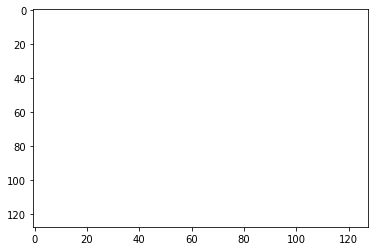

2020-11-18 09:00:27,559 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.62it/s]
2020-11-18 09:02:01,822 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.83it/s]
2020-11-18 09:03:35,976 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.19it/s]
2020-11-18 09:05:10,133 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.57it/s]
2020-11-18 09:06:44,448 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.70it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

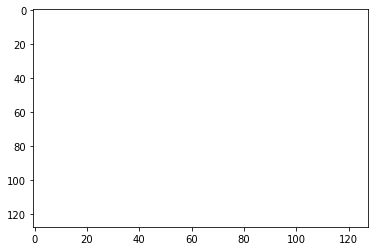

2020-11-18 09:08:18,884 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.45it/s]
2020-11-18 09:09:53,215 - pytorch_modeler.py - INFO - Epoch 36/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.56it/s]
2020-11-18 09:11:27,545 - pytorch_modeler.py - INFO - Epoch 37/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.46it/s]
2020-11-18 09:13:01,840 - pytorch_modeler.py - INFO - Epoch 38/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.54it/s]
2020-11-18 09:14:36,150 - pytorch_modeler.py - INFO - Epoch 39/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.75it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

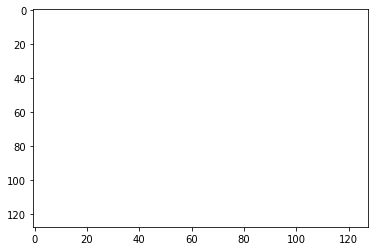

2020-11-18 09:16:10,484 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.94it/s]
2020-11-18 09:17:44,627 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.77it/s]
2020-11-18 09:19:19,048 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.44it/s]
2020-11-18 09:20:53,428 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.70it/s]
2020-11-18 09:22:27,621 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.04it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

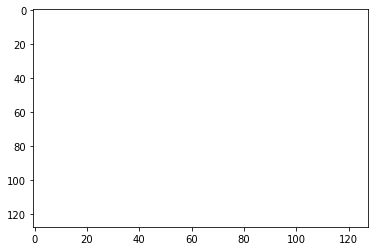

2020-11-18 09:24:01,848 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.66it/s]
2020-11-18 09:25:36,147 - pytorch_modeler.py - INFO - Epoch 46/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.07it/s]
2020-11-18 09:27:10,282 - pytorch_modeler.py - INFO - Epoch 47/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.87it/s]
2020-11-18 09:28:44,660 - pytorch_modeler.py - INFO - Epoch 48/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.99it/s]
2020-11-18 09:30:18,787 - pytorch_modeler.py - INFO - Epoch 49/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.62it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

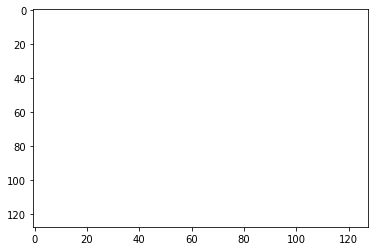

2020-11-18 09:31:53,108 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 77.97it/s]
2020-11-18 09:33:27,680 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.81it/s]
2020-11-18 09:35:01,903 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.75it/s]
2020-11-18 09:36:36,204 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.16it/s]
2020-11-18 09:38:10,633 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.94it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

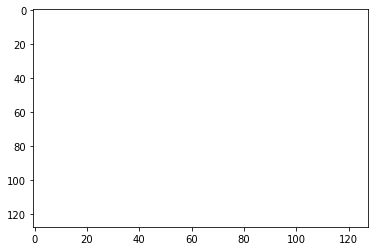

2020-11-18 09:39:44,869 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.11it/s]
2020-11-18 09:41:18,948 - pytorch_modeler.py - INFO - Epoch 56/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.71it/s]
2020-11-18 09:42:53,224 - pytorch_modeler.py - INFO - Epoch 57/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:31<00:00, 77.59it/s]
2020-11-18 09:44:27,925 - pytorch_modeler.py - INFO - Epoch 58/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.75it/s]
2020-11-18 09:46:02,156 - pytorch_modeler.py - INFO - Epoch 59/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.56it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

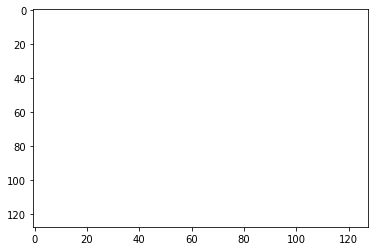

2020-11-18 09:47:36,671 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 77.77it/s]
2020-11-18 09:49:11,317 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.01it/s]
2020-11-18 09:50:45,466 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.43it/s]
2020-11-18 09:52:19,836 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.81it/s]
2020-11-18 09:53:54,016 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.06it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

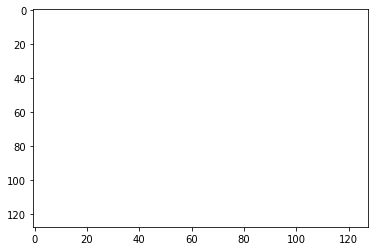

2020-11-18 09:55:28,363 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.60it/s]
2020-11-18 09:57:02,824 - pytorch_modeler.py - INFO - Epoch 66/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.39it/s]
2020-11-18 09:58:37,187 - pytorch_modeler.py - INFO - Epoch 67/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.92it/s]
2020-11-18 10:00:11,386 - pytorch_modeler.py - INFO - Epoch 68/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.51it/s]
2020-11-18 10:01:45,745 - pytorch_modeler.py - INFO - Epoch 69/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.85it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

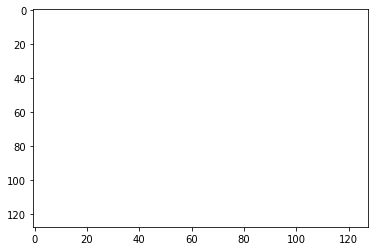

2020-11-18 10:03:20,056 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 77.76it/s]
2020-11-18 10:04:54,702 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.26it/s]
2020-11-18 10:06:29,160 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.12it/s]
2020-11-18 10:08:03,324 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.48it/s]
2020-11-18 10:09:37,762 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.76it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

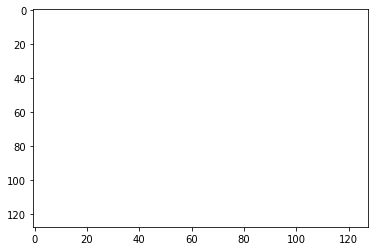

2020-11-18 10:11:12,134 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.21it/s]
2020-11-18 10:12:46,299 - pytorch_modeler.py - INFO - Epoch 76/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.13it/s]
2020-11-18 10:14:20,867 - pytorch_modeler.py - INFO - Epoch 77/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.90it/s]
2020-11-18 10:15:55,046 - pytorch_modeler.py - INFO - Epoch 78/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.08it/s]
2020-11-18 10:17:29,210 - pytorch_modeler.py - INFO - Epoch 79/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.41it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

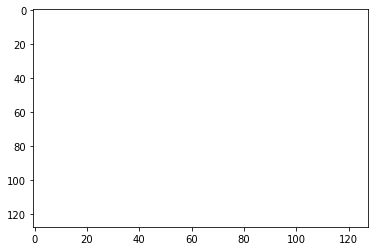

2020-11-18 10:19:03,730 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.25it/s]
2020-11-18 10:20:38,120 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.28it/s]
2020-11-18 10:22:12,158 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.45it/s]
2020-11-18 10:23:46,527 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.65it/s]
2020-11-18 10:25:20,829 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.28it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

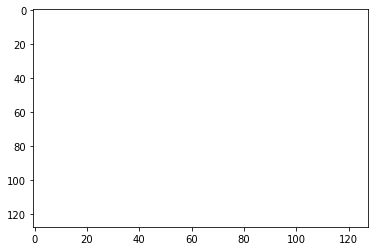

2020-11-18 10:26:55,044 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.33it/s]
2020-11-18 10:28:29,458 - pytorch_modeler.py - INFO - Epoch 86/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.96it/s]
2020-11-18 10:30:03,633 - pytorch_modeler.py - INFO - Epoch 87/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.45it/s]
2020-11-18 10:31:37,650 - pytorch_modeler.py - INFO - Epoch 88/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.79it/s]
2020-11-18 10:33:12,039 - pytorch_modeler.py - INFO - Epoch 89/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.77it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

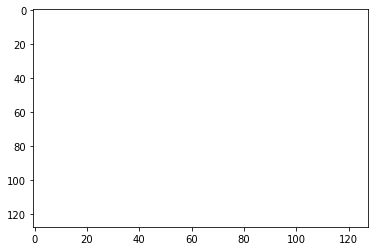

2020-11-18 10:34:46,384 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.77it/s]
2020-11-18 10:36:20,692 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.84it/s]
2020-11-18 10:37:54,947 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.28it/s]
2020-11-18 10:39:29,016 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.13it/s]
2020-11-18 10:41:03,176 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.18it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

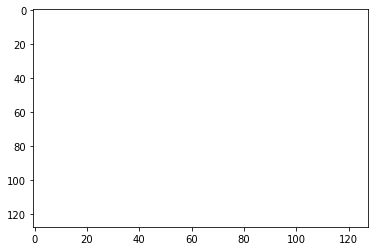

2020-11-18 10:42:37,758 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.99it/s]
2020-11-18 10:44:11,929 - pytorch_modeler.py - INFO - Epoch 96/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.17it/s]
2020-11-18 10:45:45,980 - pytorch_modeler.py - INFO - Epoch 97/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.50it/s]
2020-11-18 10:47:20,367 - pytorch_modeler.py - INFO - Epoch 98/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 79.18it/s]
2020-11-18 10:48:54,461 - pytorch_modeler.py - INFO - Epoch 99/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
100%|██████████| 2407/2407 [00:30<00:00, 78.87it/s]
/home/hiroki/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element

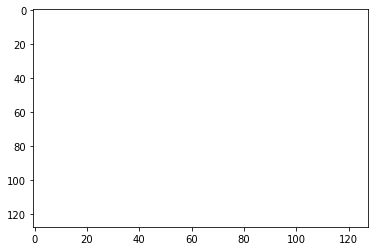

2020-11-18 10:50:28,711 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:nan, valid_AUC:0.000000, valid_pAUC:0.000000
2020-11-18 10:50:31,048 - 00_train.py - INFO - 
 success:ToyCar 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_CONV_VAE2/models/ToyCar_model.pth


elapsed time: 9521.862261772 [sec]


2020-11-18 10:50:33,267 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyConveyor
2020-11-18 10:50:33,268 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-18 10:50:33,269 - 00_train.py - INFO - TRAINING
  0%|          | 0/94 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 3452/3452 [00:59<00:00, 57.88it/s]


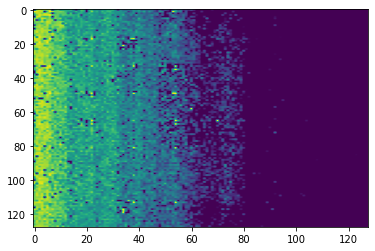

2020-11-18 10:53:30,405 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:0.035744, valid_AUC:0.487047, valid_pAUC:0.497594
100%|██████████| 3452/3452 [00:44<00:00, 78.22it/s]
2020-11-18 10:55:09,685 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:5807.624821, valid_AUC:0.483468, valid_pAUC:0.503985
100%|██████████| 3452/3452 [00:44<00:00, 78.09it/s]
2020-11-18 10:56:48,968 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:25928353476152463034679296.000000, valid_AUC:0.538013, valid_pAUC:0.508162
100%|██████████| 3452/3452 [00:44<00:00, 77.90it/s]
2020-11-18 10:58:28,377 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:62174359446791858325291008.000000, valid_AUC:0.538088, valid_pAUC:0.508135
 93%|█████████▎| 87/94 [00:53<00:04,  1.63it/s]


KeyboardInterrupt: 

In [11]:
for machine_type in machine_types:
    history = run(machine_type)
    with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
        pickle.dump(history , file)

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)